In [7]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from collections import deque
from IPython.display import Video


In [23]:

# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

In [28]:
# Define dataset paths
dataset_path = 'Downloads/United_Statess/train'
annotations_path = os.path.join(dataset_path, 'labels')
images_path = os.path.join(dataset_path, 'images')

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append([name, xmin, ymin, xmax, ymax])

    return objects

# Example of parsing an annotation file
example_annotation = parse_annotation(os.path.join(annotations_path, 'United_States_000005.xml'))
print("Parsed Annotation:", example_annotation)


Parsed Annotation: [['D00', 368, 534, 408, 640]]


In [29]:
# Get the list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

# Split the dataset into training (80%) and validation (20%)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Print split sizes
print(f"Number of training images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Number of training images: 3075
Number of test images: 769


In [30]:
def prepare_yolo_labels(image_file, annotations_path):
    xml_file = os.path.join(annotations_path, image_file.replace('.jpg', '.xml'))
    objects = parse_annotation(xml_file)

    yolo_labels = []
    for obj in objects:
        class_id = 0  # Assuming single class for simplicity, can be mapped as needed
        xmin, ymin, xmax, ymax = obj[1], obj[2], obj[3], obj[4]
        image_width, image_height = 640, 640  # Assuming fixed size, can be adjusted dynamically

        # Calculate YOLO format (center_x, center_y, width, height)
        center_x = (xmin + xmax) / 2.0 / image_width
        center_y = (ymin + ymax) / 2.0 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_labels.append(f"{class_id} {center_x} {center_y} {width} {height}")

    return yolo_labels

# Prepare labels for a training image
example_yolo_labels = prepare_yolo_labels('United_States_000008.jpg', annotations_path)
print("YOLO Labels:", example_yolo_labels)

YOLO Labels: ['0 0.3609375 0.81484375 0.709375 0.3640625']


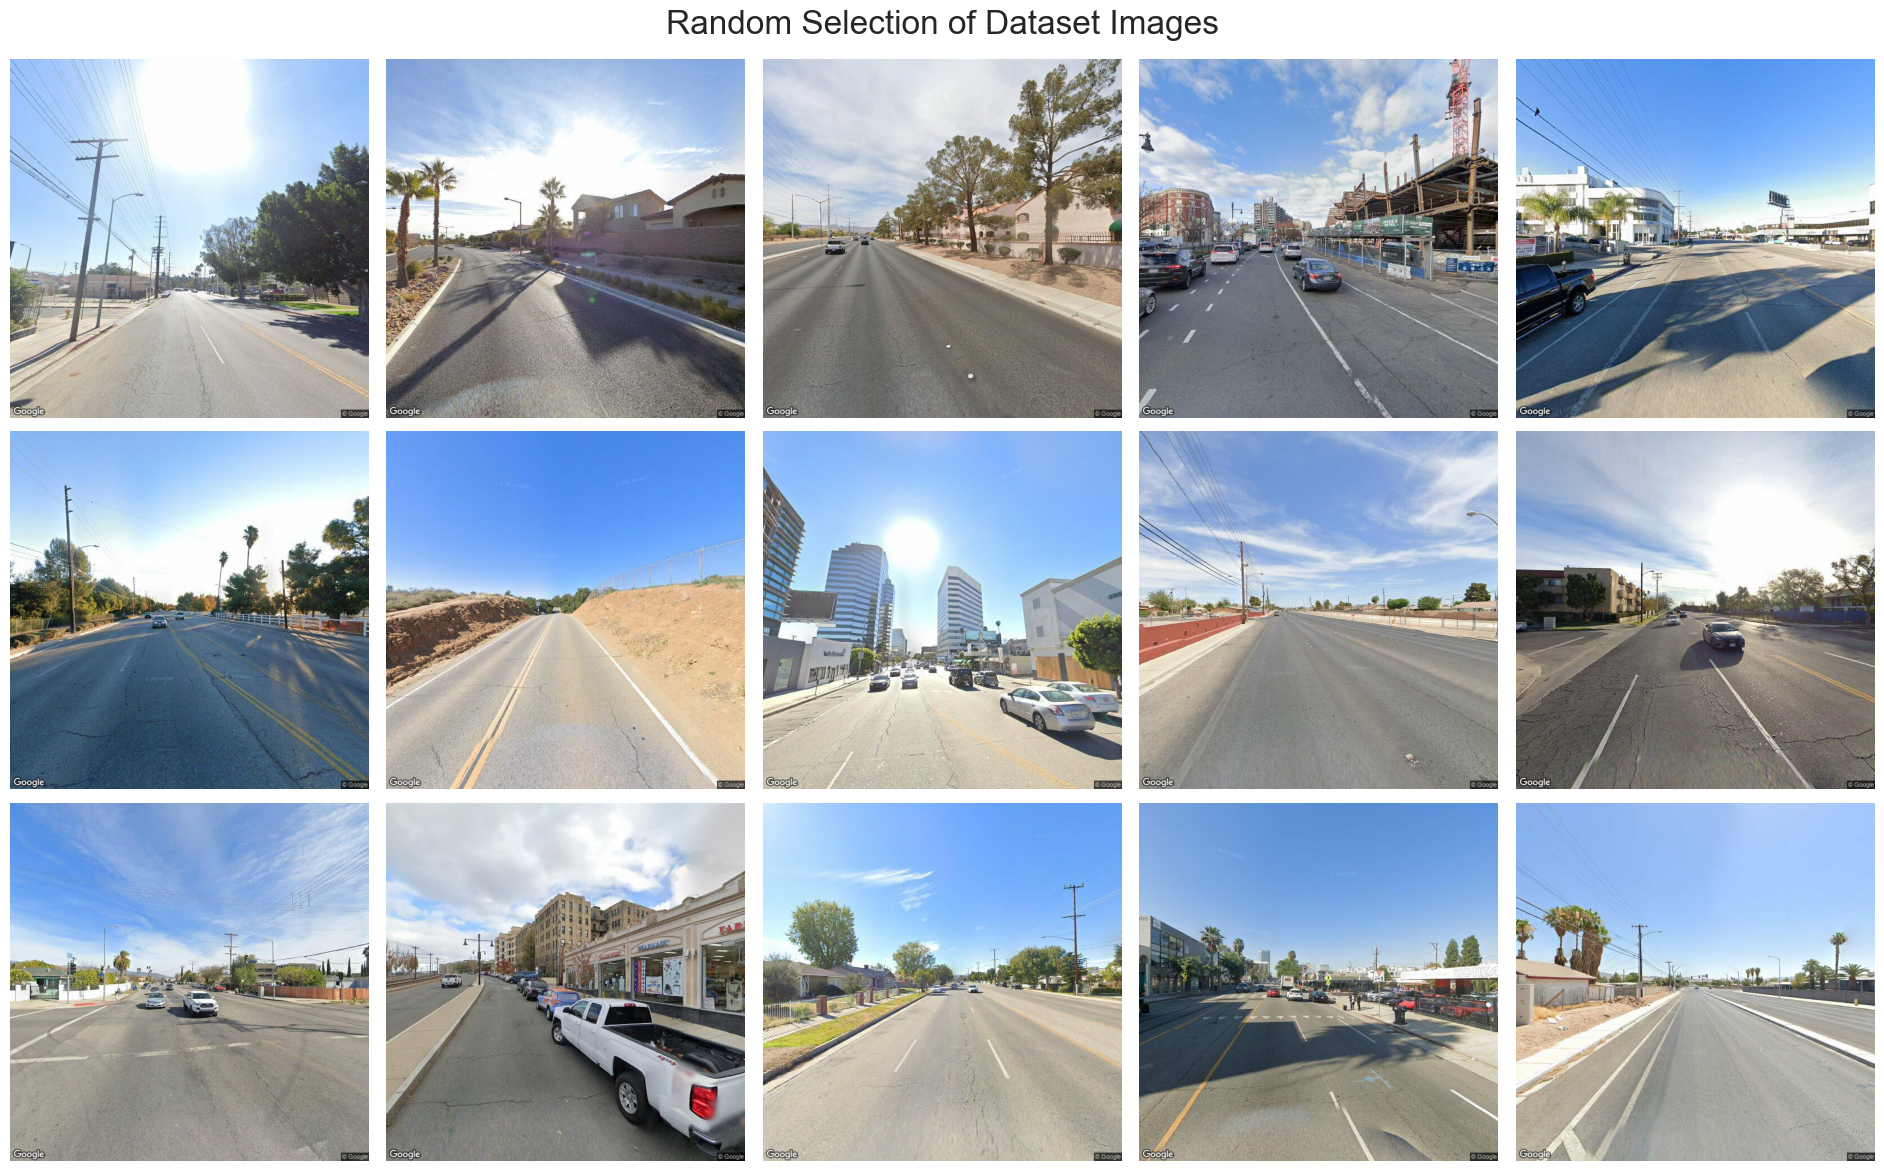

In [31]:
# Visualize a random sample of training images
random.seed(0)
random_images = random.sample(train_files, 15)

plt.figure(figsize=(19, 12))
for i, image_file in enumerate(random_images):
    image_path = os.path.join(images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.suptitle('Random Selection of Dataset Images', fontsize=24)
plt.tight_layout()
plt.show()

In [38]:
# Load the pre-trained YOLOv8 nano segmentation model
model = YOLO('yolov8n-seg.pt') 

# Set the path to the YAML file
yaml_file_path = ('Downloads/United_Statess/data1.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))



names:
- Pothole
nc: 1
train: /Users/zainahmad/Downloads/United_Statess/train/images
val: /Users/zainahmad/Downloads/United_Statess/valid/images



In [39]:

# Train the model
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=150,               # Number of epochs to train for
    imgsz=640,               # Size of input images
    batch=16,                # Batch size
    optimizer='auto',        # Optimizer choice
    lr0=0.0001,              # Initial learning rate 
    device=0,           # Use GPU for training
    seed=42                  # Random seed for reproducibility
)

Ultralytics 8.3.18 🚀 Python-3.10.9 torch-2.2.2 CPU (Apple M1 Max)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=Downloads/United_Statess/data1.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train38, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


YOLOv8n-seg summary: 261 layers, 3,263,811 parameters, 3,263,795 gradients, 12.1 GFLOPs

Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /Users/zainahmad/Downloads/United_Statess/train/labels... 0 imag

train: WARNING ⚠️ No labels found in /Users/zainahmad/Downloads/United_Statess/train/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


train: New cache created: /Users/zainahmad/Downloads/United_Statess/train/labels.cache
WARNING ⚠️ No labels found in /Users/zainahmad/Downloads/United_Statess/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: Scanning /Users/zainahmad/Downloads/United_Statess/valid/labels... 0 images

val: WARNING ⚠️ No labels found in /Users/zainahmad/Downloads/United_Statess/valid/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: /Users/zainahmad/Downloads/United_Statess/valid/labels.cache
WARNING ⚠️ No labels found in /Users/zainahmad/Downloads/United_Statess/valid/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to /Users/zainahmad/runs/segment/train38/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/zainahmad/runs/segment/train38
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G          0          0      77.68          0          0   
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        961          0          0          0          0          0          0          0          0          0
WARNING ⚠️ no labels found in segment set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G          0          0      29.07          0          0   
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        961          0          0          0          0          0          0          0          0          0
WARNING ⚠️ no labels found in segment set, can not compute metrics without labels



2 epochs completed in 0.636 hours.
Optimizer stripped from /Users/zainahmad/runs/segment/train38/weights/last.pt, 6.8MB
Optimizer stripped from /Users/zainahmad/runs/segment/train38/weights/best.pt, 6.8MB

Validating /Users/zainahmad/runs/segment/train38/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.9 torch-2.2.2 CPU (Apple M1 Max)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        961          0          0          0          0          0          0          0          0          0
WARNING ⚠️ no labels found in segment set, can not compute metrics without labels


Speed: 0.3ms preprocess, 72.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /Users/zainahmad/runs/segment/train38


In [40]:
# Validate the trained model on the validation set
metrics = model.val()

# Display the validation results
print("Validation Complete.")


Ultralytics 8.3.18 🚀 Python-3.10.9 torch-2.2.2 CPU (Apple M1 Max)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /Users/zainahmad/Downloads/United_Statess/valid/labels.cache... 0 

WARNING ⚠️ No labels found in /Users/zainahmad/Downloads/United_Statess/valid/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        961          0          0          0          0          0          0          0          0          0
WARNING ⚠️ no labels found in segment set, can not compute metrics without labels


Speed: 0.4ms preprocess, 7157.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /Users/zainahmad/runs/segment/train382
Validation Complete.


In [41]:
import cv2

# Path to the results plot generated by YOLOv8
results_file_path = os.path.join('Downloads/United_Statess', 'runs/segment/train', 'results.png')

# Read and display the image using OpenCV and Matplotlib
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Training and Validation Loss Trends', fontsize=24)
plt.axis('off')
plt.show()


[ WARN:0@10922.840] global loadsave.cpp:241 findDecoder imread_('Downloads/United_Statess/runs/segment/train/results.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /private/var/folders/jl/g2sz4kfn19s1bvv2gb_1xgh40000gn/T/pip-install-hcvep5nb/opencv-python_4695187f3dc7455c9f48d922d78edca1/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# Define paths for the precision-recall and confusion matrix plots
post_training_files_path = os.path.join('Downloads/United_Statess', 'runs/segment/train')

# List the files in the directory
print(os.listdir(post_training_files_path))

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()
